In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.model.roberta_fcn import RobertaFCNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig

# Load Data

In [2]:
import pandas as pd

In [16]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/deeptriage/gc_20.json"

In [17]:
df = pd.read_json(dataset_path)

In [18]:
len(df)

109979

In [19]:
df = df[df["owner"].notna()]

In [20]:
df.head()

,owner,issue_title,description
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...


In [21]:
# df = df.sort_values(by="reported_time")

In [22]:
df.head()

,owner,issue_title,description
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...


In [23]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

In [24]:
df = prepare_dataframe(df)
df = clean_data(df)

In [25]:
num_issues = len(df)

print(f"Total number of issues: {num_issues}")

Total number of issues: 109979


In [26]:
num_cv = 10
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

Samples per block: 10998


In [27]:
X_df = df[:samples_per_block]
y_df = df[samples_per_block : samples_per_block*2]

In [28]:
train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

In [29]:
unwanted = list(test_owners - train_owners)

In [30]:
y_df = y_df[~y_df["owner"].isin(unwanted)]

In [31]:
len(X_df), len(y_df)

(10998, 10807)

In [32]:
lbl2idx = {}

In [33]:
for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

In [34]:
X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

/tmp/ipykernel_3603148/798035673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])


In [36]:
import torch

In [44]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.labels = [label for label in df['owner_id']]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# Training

In [45]:
model = RobertaFCNClassifier(
    model_name="roberta-large",
    output_size=len(X_df.owner_id.unique()),
    embed_size=1024
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
import torch

In [ ]:
y_df

In [48]:
#Let there be 9 samples and 1 sample in class 0 and 1 respectively
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [49]:
learning_rate = 1e-5
epochs = 50
batch_size = 15

# Create sampler
# counts = np.bincount(train_df["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[train_df["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"dt_sliced_cv1_{model_name}_20_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-FCN",
        "dataset": "deeptriage",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=10, factor=0.1, threshold=1e-8)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=X_df,
    validation_dataset=y_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    scheduler=scheduler,
    wandb=wandb_config
)

trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-01-24 13:41:37.033 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-24 13:41:37.037 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


# Evaluation

In [6]:
import torch
from triagerx.evaluation.evaluator import Evaluator

In [7]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/output/RobertaCNNClassifier_5_stratify_comp-labels_WeightedRandomSampler.pt"))

evaluator = Evaluator()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from torch.utils.data import DataLoader
from triagerx.dataset.triage_dataset import TriageDataset

dataset = TriageDataset(test_df, model.tokenizer())

2024-01-19 08:02:14.302 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-19 08:02:14.304 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [9]:
loader = DataLoader(dataset, 30)

In [10]:
test_df.head(30)

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
13686,56,13687,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Change symbol/function declarations i...,This commit changes the symbol and function de...,closed,knn-k,<comment><user>knn-k</user><body>jenkins compi...,0xdaryl,"comp:jit, arch:aarch64",2021-10-13T03:38:37Z,2021-10-13T11:43:29Z,Title: AArch64: Change symbol/function declara...,1
17217,25,17220,https://github.com/eclipse-openj9/openj9/pull/...,Recognize new Class methods for Valhalla proto...,This change adds support to `constrainRecogniz...,closed,hzongaro,<comment><user>hzongaro</user><body>Daryl @0xd...,0xdaryl,"comp:jit, perf, project:valhalla",2023-04-18T20:38:30Z,2023-06-15T12:20:08Z,Title: Recognize new Class methods for Valhall...,1
4707,35,4712,https://github.com/eclipse-openj9/openj9/pull/...,Clean up of Concurrent Scavenge code on Power,Comment regarding compatibility of TM and conc...,closed,IBMJimmyk,<comment><user>IBMJimmyk</user><body>Travis CI...,gita-omr,"comp:jit, arch:power",2019-02-12T20:53:51Z,2019-02-25T18:18:26Z,Title: Clean up of Concurrent Scavenge code on...,16
7828,14,7833,https://github.com/eclipse-openj9/openj9/issue...,Compilation errors with strncpy when compiling...,The compilation warning `stringop-truncation` ...,closed,ChengJin01,<comment><user>DanHeidinga</user><body>@ChengJ...,keithc-ca,NaN,2019-11-21T21:09:53Z,2020-05-11T15:32:31Z,Title: Compilation errors with strncpy when co...,6
9941,2,9945,https://github.com/eclipse-openj9/openj9/pull/...,Fix warnings building on osx,* Use explicit boolean conditions and addition...,closed,DanHeidinga,<comment><user>pshipton</user><body>@andrewcra...,andrewcraik,comp:jit,2020-06-19T04:00:22Z,2020-06-23T13:09:16Z,Title: Fix warnings building on osx\nLabels: c...,7
7580,62,7586,https://github.com/eclipse-openj9/openj9/pull/...,Avoid load rewrites for cold escapes of immuta...,Ordinarily Escape Analysis avoids fix-up of fi...,closed,hzongaro,<comment><user>hzongaro</user><body>This chang...,andrewcraik,"bug, comp:jit",2019-10-24T17:43:02Z,2019-10-25T18:45:01Z,Title: Avoid load rewrites for cold escapes of...,7
11005,37,11006,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Revert the change for LinkageInfo wor...,This commit reverts the AArch64 part of the ch...,closed,knn-k,<comment><user>knn-k</user><body>jenkins test ...,0xdaryl,"comp:jit, arch:aarch64",2020-10-27T05:42:30Z,2020-10-27T11:36:42Z,Title: AArch64: Revert the change for LinkageI...,1
9152,90,9157,https://github.com/eclipse-openj9/openj9/pull/...,CMake: Modify arch tuning value for jit on aix,Signed-off-by: Devin Nakamura <devinn@ca.ibm.com>,closed,dnakamura,<comment><user>dnakamura</user><body>@pshipton...,pshipton,comp:build,2020-04-07T14:11:59Z,2020-07-27T17:19:32Z,Title: CMake: Modify arch tuning value for jit...,15
10204,38,10205,https://github.com/eclipse-openj9/openj9/pull/...,Add JIT Hooks Documentation,NaN,closed,dsouzai,<comment><user>mpirvu</user><body>@dsouzai Do ...,mpirvu,"comp:jit, comp:doc",2020-07-21T14:43:15Z,2020-07-28T17:35:34Z,Title: Add JIT Hooks Documentation\nLabels: co...,5
3486,56,3489,https://github.com/eclipse-openj9/openj9/pull/...,Changes to get ddrgen working on OSX,These are the changes required on the OpenJ9 s...,closed,mikezhang1234567890,<comment><user>keithc-ca</user><body>Jenkins t...,keithc-ca,comp:vm,2018-10-30T20:59:05Z,2018-11-06T17:39:37Z,Title: Changes to get ddrgen working on OSX\nL...,6


In [12]:
device = "cuda"
all_preds = []
all_labels = []

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)
        output = nn.Softmax(dim=1)(output)
        conf, classes = output.topk(10, dim=1)

        print("Pred", output.argmax(dim=1))
        print("Label", val_label.long())
        print("Top 3", classes)

        # batch_loss = criterion(output, val_label.long())
        # total_loss_val += batch_loss.item()

        # acc = (output.argmax(dim=1) == val_label).sum().item()
        
        # all_preds.append(output.cpu().numpy())
        # all_labels.append(val_label.cpu().numpy())
        
        # total_acc_val += acc

        break

Pred tensor([ 1, 37, 16,  6,  7,  7,  1, 15,  4,  2,  5,  8,  2,  1, 29, 19,  5,  1,
        17,  2, 17, 12,  1, 19, 15,  2, 21, 12,  5,  4], device='cuda:0')
Label tensor([ 1,  1, 16,  6,  7,  7,  1, 15,  5,  6,  5,  1, 31,  7,  6, 19,  5,  1,
        17,  6,  6, 12,  1, 21, 15,  2, 21, 10,  5,  7], device='cuda:0')
Top 3 tensor([[ 1,  7, 31, 15,  4,  6,  2, 11, 19, 16],
        [37, 11,  7,  1, 27, 36,  5, 19, 31, 34],
        [16,  1,  4, 15,  5,  2,  7,  6, 37, 12],
        [ 6, 17, 29, 33, 15, 11,  2, 37, 40, 39],
        [ 7,  1,  4, 11, 15, 16,  2, 19, 31,  0],
        [ 7, 11,  1, 16, 24, 19,  4, 37, 10, 17],
        [ 1, 15, 31,  7,  6,  4,  2, 19,  5, 16],
        [15,  2,  6,  4,  1,  5,  0, 17,  3, 31],
        [ 4, 19,  1,  5, 14, 31, 16, 24,  7, 37],
        [ 2,  6, 15, 39, 17,  4,  0, 12, 29,  1],
        [ 5, 19, 21,  4, 37, 24,  7,  1, 25, 16],
        [ 8,  1, 19,  4,  7, 11, 16,  0,  5, 15],
        [ 2, 15, 17,  6, 29, 39, 34, 30,  5, 22],
        [ 1,  4,  7, 16, 

In [33]:
from triagerx.dataset.triage_dataset import TriageDataset

In [36]:
import pandas as pd

In [52]:
x_df = df.copy()

In [55]:
x_df.head()

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
9,33,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie,comp:doc,2017-09-14T12:24:25Z,2017-09-14T12:42:15Z,Title: Update README.md with proper AdoptOpenJ...,0
14,28,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl,comp:jit,2017-09-14T14:30:51Z,2017-09-27T20:01:54Z,Title: Refactor and clean up CodeCacheManager\...,1
16,26,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,"comp:vm, project:panama",2017-09-14T16:10:32Z,2019-12-04T15:50:33Z,Title: WIP Add support for function pointers i...,2
21,21,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga,"jdk9, comp:vm",2017-09-14T20:53:59Z,2017-09-15T14:23:40Z,Title: fix illegal-access behaviour\nLabels: j...,2
23,19,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga,comp:build,2017-09-15T04:24:17Z,2017-11-09T14:15:08Z,Title: Enable a travis.ci-based PR build for l...,2


In [60]:
x_df["assignee_w_id"] = x_df.apply(lambda x: str(x["assignees"]) + " " + str(x["owner_id"]), axis=1)

In [63]:
x_df.head()

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id,assignee_w_id
9,33,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie,comp:doc,2017-09-14T12:24:25Z,2017-09-14T12:42:15Z,Title: Update README.md with proper AdoptOpenJ...,0,charliegracie 0
14,28,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl,comp:jit,2017-09-14T14:30:51Z,2017-09-27T20:01:54Z,Title: Refactor and clean up CodeCacheManager\...,1,0xdaryl 1
16,26,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga,"comp:vm, project:panama",2017-09-14T16:10:32Z,2019-12-04T15:50:33Z,Title: WIP Add support for function pointers i...,2,DanHeidinga 2
21,21,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga,"jdk9, comp:vm",2017-09-14T20:53:59Z,2017-09-15T14:23:40Z,Title: fix illegal-access behaviour\nLabels: j...,2,DanHeidinga 2
23,19,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga,comp:build,2017-09-15T04:24:17Z,2017-11-09T14:15:08Z,Title: Enable a travis.ci-based PR build for l...,2,DanHeidinga 2


<Axes: xlabel='assignee_w_id'>

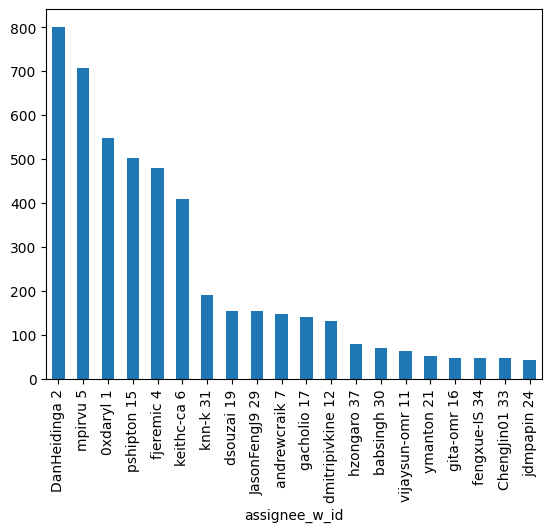

In [64]:
x_df["assignee_w_id"].value_counts()[:20].plot(kind="bar")

In [84]:
def predict(data, model):
    device = "cuda"
    model = model.cuda()

    with torch.no_grad():
        for val_input, val_label in loader:
            val_label = val_label.to(device)
            mask = val_input["attention_mask"].to(device)
            input_id = val_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            output = nn.Softmax(dim=1)(output)
            # conf, classes = output.topk(3, dim=1)

            return output.argmax(dim=1)

2024-01-18 18:40:37.707 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-18 18:40:37.709 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


In [98]:
test_df.head(30)

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
13686,56,13687,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Change symbol/function declarations i...,This commit changes the symbol and function de...,closed,knn-k,<comment><user>knn-k</user><body>jenkins compi...,0xdaryl,"comp:jit, arch:aarch64",2021-10-13T03:38:37Z,2021-10-13T11:43:29Z,Title: AArch64: Change symbol/function declara...,1
17217,25,17220,https://github.com/eclipse-openj9/openj9/pull/...,Recognize new Class methods for Valhalla proto...,This change adds support to `constrainRecogniz...,closed,hzongaro,<comment><user>hzongaro</user><body>Daryl @0xd...,0xdaryl,"comp:jit, perf, project:valhalla",2023-04-18T20:38:30Z,2023-06-15T12:20:08Z,Title: Recognize new Class methods for Valhall...,1
4707,35,4712,https://github.com/eclipse-openj9/openj9/pull/...,Clean up of Concurrent Scavenge code on Power,Comment regarding compatibility of TM and conc...,closed,IBMJimmyk,<comment><user>IBMJimmyk</user><body>Travis CI...,gita-omr,"comp:jit, arch:power",2019-02-12T20:53:51Z,2019-02-25T18:18:26Z,Title: Clean up of Concurrent Scavenge code on...,16
7828,14,7833,https://github.com/eclipse-openj9/openj9/issue...,Compilation errors with strncpy when compiling...,The compilation warning `stringop-truncation` ...,closed,ChengJin01,<comment><user>DanHeidinga</user><body>@ChengJ...,keithc-ca,NaN,2019-11-21T21:09:53Z,2020-05-11T15:32:31Z,Title: Compilation errors with strncpy when co...,6
9941,2,9945,https://github.com/eclipse-openj9/openj9/pull/...,Fix warnings building on osx,* Use explicit boolean conditions and addition...,closed,DanHeidinga,<comment><user>pshipton</user><body>@andrewcra...,andrewcraik,comp:jit,2020-06-19T04:00:22Z,2020-06-23T13:09:16Z,Title: Fix warnings building on osx\nLabels: c...,7
7580,62,7586,https://github.com/eclipse-openj9/openj9/pull/...,Avoid load rewrites for cold escapes of immuta...,Ordinarily Escape Analysis avoids fix-up of fi...,closed,hzongaro,<comment><user>hzongaro</user><body>This chang...,andrewcraik,"bug, comp:jit",2019-10-24T17:43:02Z,2019-10-25T18:45:01Z,Title: Avoid load rewrites for cold escapes of...,7
11005,37,11006,https://github.com/eclipse-openj9/openj9/pull/...,AArch64: Revert the change for LinkageInfo wor...,This commit reverts the AArch64 part of the ch...,closed,knn-k,<comment><user>knn-k</user><body>jenkins test ...,0xdaryl,"comp:jit, arch:aarch64",2020-10-27T05:42:30Z,2020-10-27T11:36:42Z,Title: AArch64: Revert the change for LinkageI...,1
9152,90,9157,https://github.com/eclipse-openj9/openj9/pull/...,CMake: Modify arch tuning value for jit on aix,Signed-off-by: Devin Nakamura <devinn@ca.ibm.com>,closed,dnakamura,<comment><user>dnakamura</user><body>@pshipton...,pshipton,comp:build,2020-04-07T14:11:59Z,2020-07-27T17:19:32Z,Title: CMake: Modify arch tuning value for jit...,15
10204,38,10205,https://github.com/eclipse-openj9/openj9/pull/...,Add JIT Hooks Documentation,NaN,closed,dsouzai,<comment><user>mpirvu</user><body>@dsouzai Do ...,mpirvu,"comp:jit, comp:doc",2020-07-21T14:43:15Z,2020-07-28T17:35:34Z,Title: Add JIT Hooks Documentation\nLabels: co...,5
3486,56,3489,https://github.com/eclipse-openj9/openj9/pull/...,Changes to get ddrgen working on OSX,These are the changes required on the OpenJ9 s...,closed,mikezhang1234567890,<comment><user>keithc-ca</user><body>Jenkins t...,keithc-ca,comp:vm,2018-10-30T20:59:05Z,2018-11-06T17:39:37Z,Title: Changes to get ddrgen working on OSX\nL...,6


In [99]:
test_df[25:26]

,Unnamed: 0,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees,labels,created_at,closed_at,text,owner_id
3600,42,3605,https://github.com/eclipse-openj9/openj9/pull/...,Eliminate redundant bytecode size table,Information in JavaBytecodeRelocation is avail...,closed,gacholio,<comment><user>gacholio</user><body>jenkins te...,DanHeidinga,comp:vm,2018-11-07T22:48:27Z,2018-11-12T14:54:11Z,Title: Eliminate redundant bytecode size table...,2


In [100]:
dx = test_df[25:26]
print(dx["assignees"])

dataset = TriageDataset(dx, model.tokenizer())

predict(dataset, model)

2024-01-18 18:45:30.173 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-01-18 18:45:30.175 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...


3600    DanHeidinga
Name: assignees, dtype: object


tensor([1], device='cuda:0')

In [17]:
# all_preds[0]

In [24]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

In [19]:
# set(all_labels)

In [25]:
all_preds[0]

array([ 1, 31,  7])

In [26]:
sum(all_preds == all_labels)

ValueError: operands could not be broadcast together with shapes (802,3) (802,) 

In [20]:
# set(all_labels) - set(all_preds)

{0, 3, 13, 18, 20, 22, 23, 25, 28, 32, 35, 38, 41, 45, 46, 47, 48}

In [20]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-18 18:06:22.600 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-18 18:06:35.774 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 3 score...
2024-01-18 18:06:35.779 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 3 score: 0.7880299251870324


0.7880299251870324

In [21]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

2024-01-18 18:06:38.457 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:22 - Calculating predications...
2024-01-18 18:06:51.644 | DEBUG    | triagerx.evaluation.evaluator:calculate_top_k_accuray:52 - Calculating top 5 score...
2024-01-18 18:06:51.648 | INFO     | triagerx.evaluation.evaluator:calculate_top_k_accuray:55 - Top 5 score: 0.8690773067331671


0.8690773067331671